In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from xml.etree import ElementTree
from xml.dom import minidom
import collections
%matplotlib inline

In [ ]:
base_path = '/content/drive/MyDrive/ss-dataset/'

damageTypes=["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44"]

In [ ]:
cls_names = []
total_images = 0
file_list = [filename for filename in os.listdir(base_path + 'annotations/') if not filename.startswith('.')]

for file in file_list:
        total_images = total_images + 1
        if file =='.DS_Store':
            pass
        else:
            infile_xml = open(base_path +'/annotations/' +file)
            tree = ElementTree.parse(infile_xml)
            root = tree.getroot()
            for obj in root.iter('object'):
                cls_name = obj.find('name').text
                cls_names.append(cls_name)

print("total")
print("# of images：" + str(total_images))
print("# of labels：" + str(len(cls_names)))

total
# of images：384
# of labels：390


D00 : 79
D01 : 7
D10 : 2
D11 : 5
D20 : 89
D40 : 148
D43 : 7
D44 : 50


<Axes: >

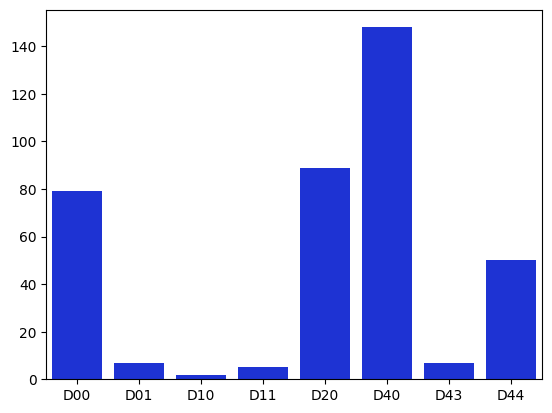

In [ ]:
count_dict = collections.Counter(cls_names)
cls_count = []
for damageType in damageTypes:
    print(str(damageType) + ' : ' + str(count_dict[damageType]))
    cls_count.append(count_dict[damageType])

sns.set_palette("winter", 8)
sns.barplot(x=damageTypes, y=cls_count)

In [ ]:
def draw_images(image_file):
    gov = image_file.split('_')[0]
    img = cv2.imread(base_path + '/images/' + image_file.split('.')[0] + '.jpg')

    infile_xml = open(base_path + '/annotations/' +image_file)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
    return img

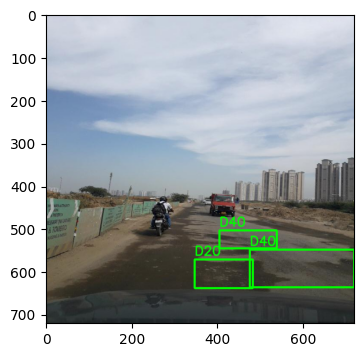

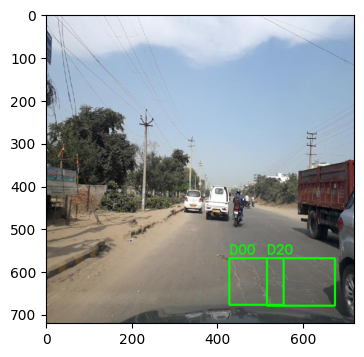

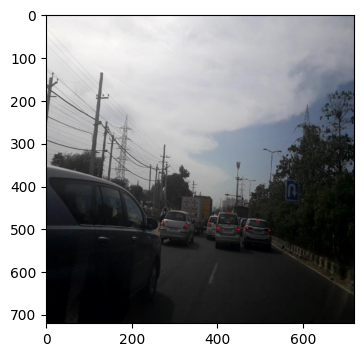

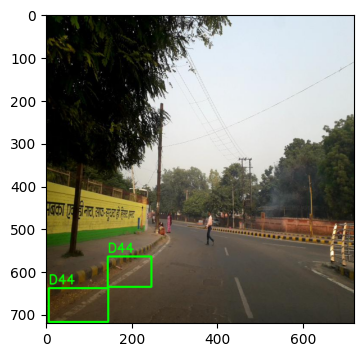

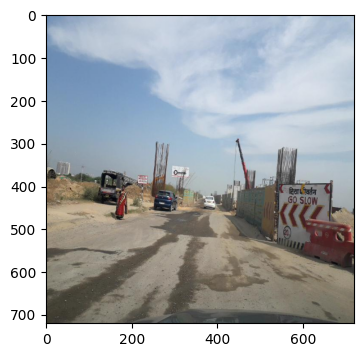

In [ ]:
import matplotlib.pyplot as plt
import random

random_image_files = random.sample(file_list, 5)

for image_file in random_image_files:
    img = draw_images(image_file)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [ ]:
# Function to parse XML annotations
def parse_annotation(annotation_path):
    tree = ElementTree.parse(annotation_path)
    root = tree.getroot()

    image_info = {
        'filename': root.find('filename').text,
        'objects': []
    }

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        image_info['objects'].append({
            'class': cls_name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return image_info

# Load dataset
def load_dataset(base_path):
    annotations_dir = os.path.join(base_path, 'annotations/')
    images_dir = os.path.join(base_path, 'images/')

    file_list = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]

    data = []
    for xml_file in file_list:
        annotation_path = os.path.join(annotations_dir, xml_file)
        image_info = parse_annotation(annotation_path)

        # For classification, we'll use the first object's class as the image label
        if image_info['objects']:
            # Get the dominant class in the image (most frequent)
            classes = [obj['class'] for obj in image_info['objects']]
            dominant_class = max(set(classes), key=classes.count)

            image_path = os.path.join(images_dir, image_info['filename'])
            if os.path.exists(image_path):
                data.append({
                    'image_path': image_path,
                    'label': dominant_class
                })

    return pd.DataFrame(data)

# Load the dataset
df = load_dataset(base_path)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {num_classes}")

Train samples: 124
Validation samples: 14
Test samples: 35
Number of classes: 8


In [ ]:
# Configuration
IMAGE_SIZE = (224, 224)  # ViT typically uses 224x224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image - 0.5) / 0.5  # Normalization to [-1, 1]
    return image, label

def prepare_dataloader(df, batch_size=BATCH_SIZE, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['image_path'].values, df['label_encoded'].values)
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

train_ds = prepare_dataloader(train_df, shuffle=True)
val_ds = prepare_dataloader(val_df)
test_ds = prepare_dataloader(test_df)

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)  # Handle the trainable parameter and other Layer args
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

# Now recreate your model with the fixed layers
def create_vit_classifier(input_shape, num_classes, patch_size=16, projection_dim=64, num_heads=4, transformer_layers=8):
    inputs = layers.Input(shape=input_shape)

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches
    num_patches = (input_shape[0] // patch_size) ** 2
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = keras.Sequential(
            [
                layers.Dense(units=projection_dim * 2, activation="gelu"),
                layers.Dense(units=projection_dim, activation="gelu"),
            ]
        )(x3)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP
    features = layers.Dense(units=projection_dim * 2, activation="gelu")(representation)
    features = layers.Dropout(0.5)(features)

    # Classify outputs
    logits = layers.Dense(units=num_classes)(features)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Create and compile the model again
input_shape = (224, 224, 3)  # Adjust if your IMAGE_SIZE is different
num_classes = len(damageTypes)  # Make sure damageTypes is defined

vit_model = create_vit_classifier(
    input_shape=input_shape,
    num_classes=num_classes,
    patch_size=16,
    projection_dim=64,
    num_heads=4,
    transformer_layers=8
)

vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

vit_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, None, 768) │          0 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_2     │ (None, 196, 64)   │     61,760 │ patches_2[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ patch_encoder_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 196, 64)   │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 196, 64)   │          0 │ sequential_16[0]… │
│                     │                   │            │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 196, 64)   │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 196, 64)   │          0 │ sequential_17[0]… │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_35[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 2,334,280 (8.90 MB)

 Trainable params: 2,334,280 (8.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1678 - loss: 8.1943

4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.1810 - loss: 8.3471 - val_accuracy: 0.0714 - val_loss: 2.1501
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1896 - loss: 3.4246

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.1888 - loss: 3.4136 - val_accuracy: 0.3571 - val_loss: 1.5283
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2816 - loss: 1.9810 - val_accuracy: 0.3571 - val_loss: 1.7782
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.1858 - loss: 2.2061 - val_accuracy: 0.1429 - val_loss: 1.9627
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1170 - loss: 2.0022 - val_accuracy: 0.3571 - val_loss: 1.7142
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2192 - loss: 1.9042 - val_accuracy: 0.3571 - val_loss: 1.7371
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.2320 - loss: 1.9282 - val_accuracy: 0.3571 - val_loss: 1.9427
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.2223 - loss: 1.9436 - val_accuracy: 0.3571 - val_loss: 1.6928
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.2872 - loss: 2.1011 - val_accuracy: 0.3571 - val_loss: 1.6726
Epoch 10/20
4/4 ━━━

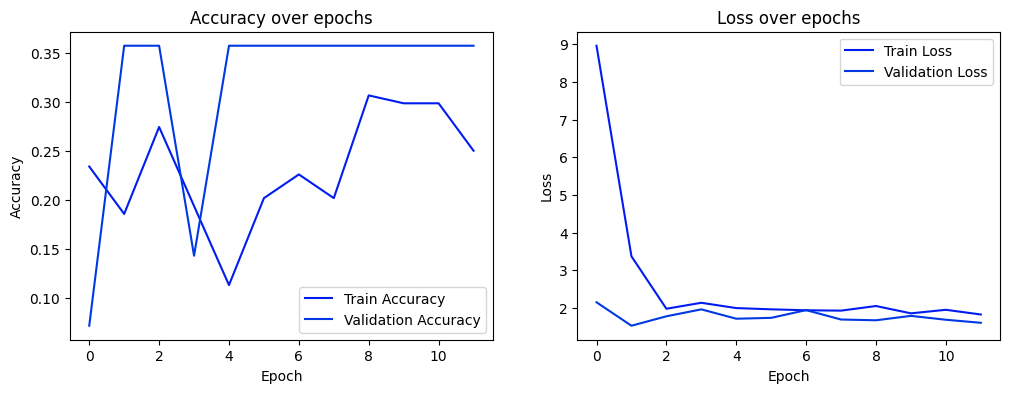

In [ ]:
# Add callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "vit_damage_classifier.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

# Train the model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
from tensorflow import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# ✅ FIXED: Allow extra Keras arguments using **kwargs
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# ✅ Now this will work without TypeError
vit_model = keras.models.load_model(
    "vit_damage_classifier.h5",
    custom_objects={"Patches": Patches, "PatchEncoder": PatchEncoder}
)

# Add softmax for clean probability outputs
probability_model = keras.Sequential([
    vit_model,
    layers.Softmax()
])

# Function to visualize predictions
def visualize_predictions(dataset, model, label_encoder, num_samples=5):
    plt.figure(figsize=(15, 10))

    for images, labels in dataset.take(1):
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i+1)

            # Undo normalization
            img = images[i].numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype('uint8')
            true_label = label_encoder.inverse_transform([labels[i].numpy()])[0]

            # Predict
            predictions = model.predict(tf.expand_dims(images[i], 0))
            predicted_label = label_encoder.classes_[np.argmax(predictions)]
            confidence = np.max(predictions)

            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Call the function to view sample predictions
visualize_predictions(test_ds, probability_model, label_encoder)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3536 - loss: 1.6641
Test accuracy: 0.3429


ValueError: Unknown layer: 'Patches'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.